- donner à GPT plus d'infos (pour donner plus d'infos), donner la date de naissance, pays d'origine
- le faire sur le top des individus
- monter que la proportion de gens modeste augmente quand l'indice culturel augmente
- sampler 200 personnes, puis piocher dedans pour avoir une répartiiton égale de chaque classe (puis envoyer à Nicolas)
- la propbablité d^'etre de classe sociale défavorisé augmente

In [1]:
import openai
import time
import pandas as pd
import os
import re
from typing import List, Dict, Optional, Tuple
from tqdm import tqdm


def get_social_origin(author_name: str) -> Tuple[Optional[str], str, str]:
    """
    Query OpenAI API to determine the social origin of a cultural producer.
    Returns a tuple of (classification, explanation, sources) where classification is
    'Elite', 'Middle Class', 'Subsistence', or None if not found.
    """
    try:
        # Create the prompt for the API with request for sources
        prompt = f"""I'm researching the BIRTH CIRCUMSTANCES and FAMILY BACKGROUND of {author_name}. Please focus ONLY on their social origin and family circumstances BEFORE they became famous.

Classify their BIRTH and CHILDHOOD social class according to this specific typology:

1. Elite (wealthy aristocrats, ruling class, nobility)
2. Middle Class (merchants, artisans, skilled craftspeople, landowners, teachers)
3. Subsistence (people with minimal resources, peasants, laborers, slaves)

DO NOT consider their later accomplishments or fame. ONLY consider:
- Parents' occupations and social standing
- Family wealth at the time of birth and childhood
- Access to education BECAUSE of family background (not merit)
- Early life housing and living conditions
- Inherited privileges or disadvantages

Format your answer as:
Classification: [Elite/Middle Class/Subsistence]
Explanation: [Evidence specifically about family origins, NOT later achievements]
Sources: [List historical sources, ancient texts, or scholarly references]

If you cannot determine with reasonable confidence, respond with:
Classification: Unknown
Explanation: [Why it's unknown]
Sources: [Any potential sources that could provide this information]"""
        
        # Call the OpenAI API
        response = openai.chat.completions.create(
            model="gpt-4",  # or another appropriate model
            messages=[
                {"role": "system", "content": "You are a historical researcher specializing in social class origins. Focus exclusively on birth circumstances and family backgrounds, NOT on later accomplishments or acquired status. Provide evidence from primary sources whenever possible."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.2,  # Low temperature for more consistent answers
            max_tokens=300    # Increased to allow for explanation and sources
        )
        
        # Extract the response text
        answer = response.choices[0].message.content.strip()
        
        # Process the answer to extract classification, explanation, and sources
        classification = None
        explanation = "No explanation provided"
        sources = "No sources provided"
        
        # Try to parse the structured response
        try:
            # First check if there's a Sources section
            if "Sources:" in answer:
                parts = answer.split("Sources:", 1)
                main_text = parts[0].strip()
                sources = parts[1].strip()
                
                # Now parse the main text for Classification and Explanation
                if "Explanation:" in main_text:
                    sections = main_text.split("Explanation:", 1)
                    class_line = sections[0].strip()
                    explanation = sections[1].strip()
                    
                    if "Classification:" in class_line:
                        classification_text = class_line.split("Classification:")[1].strip()
                        if "Elite" in classification_text:
                            classification = "Elite"
                        elif "Middle Class" in classification_text:
                            classification = "Middle Class"
                        elif "Subsistence" in classification_text:
                            classification = "Subsistence"
            else:
                # If no Sources section, just parse for Classification and Explanation
                if "Explanation:" in answer:
                    parts = answer.split("Explanation:", 1)
                    class_line = parts[0].strip()
                    explanation = parts[1].strip()
                    
                    if "Classification:" in class_line:
                        classification_text = class_line.split("Classification:")[1].strip()
                        if "Elite" in classification_text:
                            classification = "Elite"
                        elif "Middle Class" in classification_text:
                            classification = "Middle Class"
                        elif "Subsistence" in classification_text:
                            classification = "Subsistence"
                
                # Look for sources in the explanation
                if "source" in explanation.lower() or "according to" in explanation.lower() or "mentioned in" in explanation.lower():
                    # Try to extract likely source statements
                    source_patterns = [
                        r"according to [^.]*\.",
                        r"mentioned (?:by|in) [^.]*\.",
                        r"sources? (?:such as|like|including) [^.]*\.",
                        r"(?:historical|ancient) (?:records|texts|documents) [^.]*\."
                    ]
                    potential_sources = []
                    for pattern in source_patterns:
                        matches = re.findall(pattern, explanation, re.IGNORECASE)
                        potential_sources.extend(matches)
                    
                    if potential_sources:
                        sources = " ".join(potential_sources)
                    
            # Fallback to simpler parsing if structured parsing failed
            if classification is None:
                if "Elite" in answer:
                    classification = "Elite"
                elif "Middle Class" in answer:
                    classification = "Middle Class"
                elif "Subsistence" in answer:
                    classification = "Subsistence"
        
        except Exception as parsing_error:
            print(f"Error parsing response for {author_name}: {parsing_error}")
            
            # Simple classification extraction as fallback
            if "Elite" in answer:
                classification = "Elite"
            elif "Middle Class" in answer:
                classification = "Middle Class"
            elif "Subsistence" in answer:
                classification = "Subsistence"
            
            # Just use the full answer as explanation if parsing failed
            explanation = answer
        
        return classification, explanation, sources
            
    except Exception as e:
        print(f"Error processing {author_name}: {e}")
        return None, f"Error: {str(e)}", "No sources due to error"

def process_authors(authors: List[str]) -> Dict[str, Dict[str, str]]:
    """Process a list of authors and return their social origins with explanations and sources."""
    results = {}
    
    for i, author in tqdm(enumerate(authors), total=len(authors)):
        print(f"\nProcessing ({i+1}/{len(authors)}): {author}")
        classification, explanation, sources = get_social_origin(author)
        
        results[author] = {
            "classification": classification,
            "explanation": explanation,
            "sources": sources
        }
        
        # Print immediate result
        print(f"  Result: {classification if classification else 'None'}")
        print(f"  Explanation: {explanation}")
        print(f"  Sources: {sources}")
        
        # Add a delay to avoid rate limiting
        # time.sleep(1)
    
    return results


In [ ]:
import openai
import time
import pandas as pd
import os
import re
from typing import List, Dict, Optional, Tuple
from tqdm import tqdm


def get_social_origin(author_name: str, birth_year: int, country: str) -> Tuple[Optional[str], str, str]:
    """
    Query OpenAI API to determine the social origin of a cultural producer.
    Returns a tuple of (classification, explanation, sources) where classification is
    'Elite', 'Middle Class', 'Subsistence', or None if not found.
    
    Parameters:
    - author_name: The name of the author to research
    - birth_year: The approximate year of birth 
    - country: The modern equivalent country in which the individual was likely born
    """
    try:
        # Create the prompt for the API with request for sources and include birth year and country
        prompt = f"""I'm researching the BIRTH CIRCUMSTANCES and FAMILY BACKGROUND of {author_name}, born around {birth_year} in what is now {country}. Please focus ONLY on their social origin and family circumstances BEFORE they became famous.

Classify their BIRTH and CHILDHOOD social class according to this specific typology:

1. Elite (wealthy aristocrats, ruling class, nobility)
2. Middle Class (merchants, artisans, skilled craftspeople, landowners, teachers)
3. Subsistence (people with minimal resources, peasants, laborers, slaves)

Consider the social structure and economic context of {country} in the late {birth_year//100}00s.

DO NOT consider their later accomplishments or fame. ONLY consider:
- Parents' occupations and social standing
- Family wealth at the time of birth and childhood
- Access to education BECAUSE of family background (not merit)
- Early life housing and living conditions
- Inherited privileges or disadvantages

Format your answer as:
Classification: [Elite/Middle Class/Subsistence]
Explanation: [Evidence specifically about family origins, NOT later achievements]
Sources: [List historical sources, ancient texts, or scholarly references]

If you cannot determine with reasonable confidence, respond with:
Classification: Unknown
Explanation: [Why it's unknown]
Sources: [Any potential sources that could provide this information]"""
        
        # Call the OpenAI API
        response = openai.chat.completions.create(
            model="gpt-4",  # or another appropriate model
            messages=[
                {"role": "system", "content": "You are a historical researcher specializing in social class origins. Focus exclusively on birth circumstances and family backgrounds, NOT on later accomplishments or acquired status. Provide evidence from primary sources whenever possible."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.2,  # Low temperature for more consistent answers
            max_tokens=300    # Increased to allow for explanation and sources
        )
        
        # Extract the response text
        answer = response.choices[0].message.content.strip()
        
        # Process the answer to extract classification, explanation, and sources
        classification = None
        explanation = "No explanation provided"
        sources = "No sources provided"
        
        # Try to parse the structured response
        try:
            # First check if there's a Sources section
            if "Sources:" in answer:
                parts = answer.split("Sources:", 1)
                main_text = parts[0].strip()
                sources = parts[1].strip()
                
                # Now parse the main text for Classification and Explanation
                if "Explanation:" in main_text:
                    sections = main_text.split("Explanation:", 1)
                    class_line = sections[0].strip()
                    explanation = sections[1].strip()
                    
                    if "Classification:" in class_line:
                        classification_text = class_line.split("Classification:")[1].strip()
                        if "Elite" in classification_text:
                            classification = "Elite"
                        elif "Middle Class" in classification_text:
                            classification = "Middle Class"
                        elif "Subsistence" in classification_text:
                            classification = "Subsistence"
            else:
                # If no Sources section, just parse for Classification and Explanation
                if "Explanation:" in answer:
                    parts = answer.split("Explanation:", 1)
                    class_line = parts[0].strip()
                    explanation = parts[1].strip()
                    
                    if "Classification:" in class_line:
                        classification_text = class_line.split("Classification:")[1].strip()
                        if "Elite" in classification_text:
                            classification = "Elite"
                        elif "Middle Class" in classification_text:
                            classification = "Middle Class"
                        elif "Subsistence" in classification_text:
                            classification = "Subsistence"
                
                # Look for sources in the explanation
                if "source" in explanation.lower() or "according to" in explanation.lower() or "mentioned in" in explanation.lower():
                    # Try to extract likely source statements
                    source_patterns = [
                        r"according to [^.]*\.",
                        r"mentioned (?:by|in) [^.]*\.",
                        r"sources? (?:such as|like|including) [^.]*\.",
                        r"(?:historical|ancient) (?:records|texts|documents) [^.]*\."
                    ]
                    potential_sources = []
                    for pattern in source_patterns:
                        matches = re.findall(pattern, explanation, re.IGNORECASE)
                        potential_sources.extend(matches)
                    
                    if potential_sources:
                        sources = " ".join(potential_sources)
                    
            # Fallback to simpler parsing if structured parsing failed
            if classification is None:
                if "Elite" in answer:
                    classification = "Elite"
                elif "Middle Class" in answer:
                    classification = "Middle Class"
                elif "Subsistence" in answer:
                    classification = "Subsistence"
        
        except Exception as parsing_error:
            print(f"Error parsing response for {author_name}: {parsing_error}")
            
            # Simple classification extraction as fallback
            if "Elite" in answer:
                classification = "Elite"
            elif "Middle Class" in answer:
                classification = "Middle Class"
            elif "Subsistence" in answer:
                classification = "Subsistence"
            
            # Just use the full answer as explanation if parsing failed
            explanation = answer
        
        return classification, explanation, sources
            
    except Exception as e:
        print(f"Error processing {author_name}: {e}")
        return None, f"Error: {str(e)}", "No sources due to error"


def process_authors(author_data: pd.DataFrame) -> Dict[str, Dict[str, str]]:
    """
    Process authors from a DataFrame and return their social origins with explanations and sources.
    
    Parameters:
    - author_data: DataFrame containing columns 'individual_name', 'birthyear', 'country_name', 
                  and 'individual_wikidata_id'
    
    Returns:
    - Dictionary with author names as keys, and dictionaries of classification, explanation, sources,
      and metadata as values
    """
    results = {}
    
    for i, row in tqdm(enumerate(author_data.itertuples()), total=len(author_data)):
        try:
            author = row.individual_name
            birth_year = int(row.birthyear) if not pd.isna(row.birthyear) else None
            country = row.country_name if not pd.isna(row.country_name) else "unknown location"
            wikidata_id = row.individual_wikidata_id
            
            print(f"\nProcessing ({i+1}/{len(author_data)}): {author} (ID: {wikidata_id}), born {birth_year} in {country}")
            
            # Skip if missing critical information
            if birth_year is None:
                print(f"  Skipping {author} (ID: {wikidata_id}) - missing birth year")
                continue
                
            classification, explanation, sources = get_social_origin(author, birth_year, country)
            
            # Use Wikidata ID as the key for more reliable identification
            results[wikidata_id] = {
                "individual_name": author,
                "individual_wikidata_id": wikidata_id,
                "birth_year": birth_year,
                "country": country,
                "classification": classification,
                "explanation": explanation,
                "sources": sources
            }
            
            # Print immediate result
            print(f"  Result: {classification if classification else 'None'}")
            print(f"  Explanation: {explanation[:100]}..." if len(explanation) > 100 else f"  Explanation: {explanation}")
            print(f"  Sources: {sources[:100]}..." if len(sources) > 100 else f"  Sources: {sources}")
            
            # Add a delay to avoid rate limiting
            # time.sleep(1)
            
        except Exception as e:
            print(f"Error processing row {i} ({getattr(row, 'individual_name', 'unknown')}): {e}")
            # Continue with the next author rather than stopping the entire process
            continue
    
    return results


import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Get API key from environment variables
openai.api_key = os.environ.get("OPENAI_API_KEY")


In [3]:
import os
import sqlite3

from dotenv import load_dotenv
load_dotenv()


DB_PATH = os.getenv("DB_PATH")

conn = sqlite3.connect(DB_PATH)
pd.options.mode.chained_assignment = None

only_country = False

# Individuals Regions
df_ind = pd.read_sql_query("SELECT * FROM individuals_main_information", conn)
df_ind = df_ind[['individual_wikidata_id', 'birthyear', 'country_name']]


df = pd.read_csv('db_extract/df_individuals_score.csv', index_col=[0])
data = df.sort_values('score', ascending=False)
data = data[['individual_wikidata_id', 'individual_name', 'score', 'productive_year']].drop_duplicates()

data = pd.merge(data, df_ind, on = 'individual_wikidata_id')
df_regions = pd.read_sql_query("SELECT * FROM individuals_regions", conn)
df_regions = df_regions[['individual_wikidata_id', 'region_name']].drop_duplicates()

data = pd.merge(data, df_regions, on = 'individual_wikidata_id')


data = data.reset_index(drop=True)
#data = data.head(3000)

In [4]:
data['region_name'].value_counts()

region_name
Western Europe         131463
Northwestern Europe    104901
German world            41555
Germany                 31354
Southwestern Europe     26562
France                  25260
Eastern Europe          20490
Italy                   18516
British Islands         17734
United Kingdom          17019
Northern France         15686
Northern Italy          13397
Low countries           12022
Central Europe          11754
North America            9493
Nordic countries         8254
Netherlands              7733
Spain                    6997
Austria                  6712
East Slavic              5421
Southern France          5299
Belgium                  4288
Sweden                   3854
Southern Italy           3740
Switzerland              3493
Denmark                  2702
Ottoman world            2295
Muslim world             2259
Chinese world            2220
mediterranean World      1910
Balkans                  1792
Japan                    1711
Arabic world             169

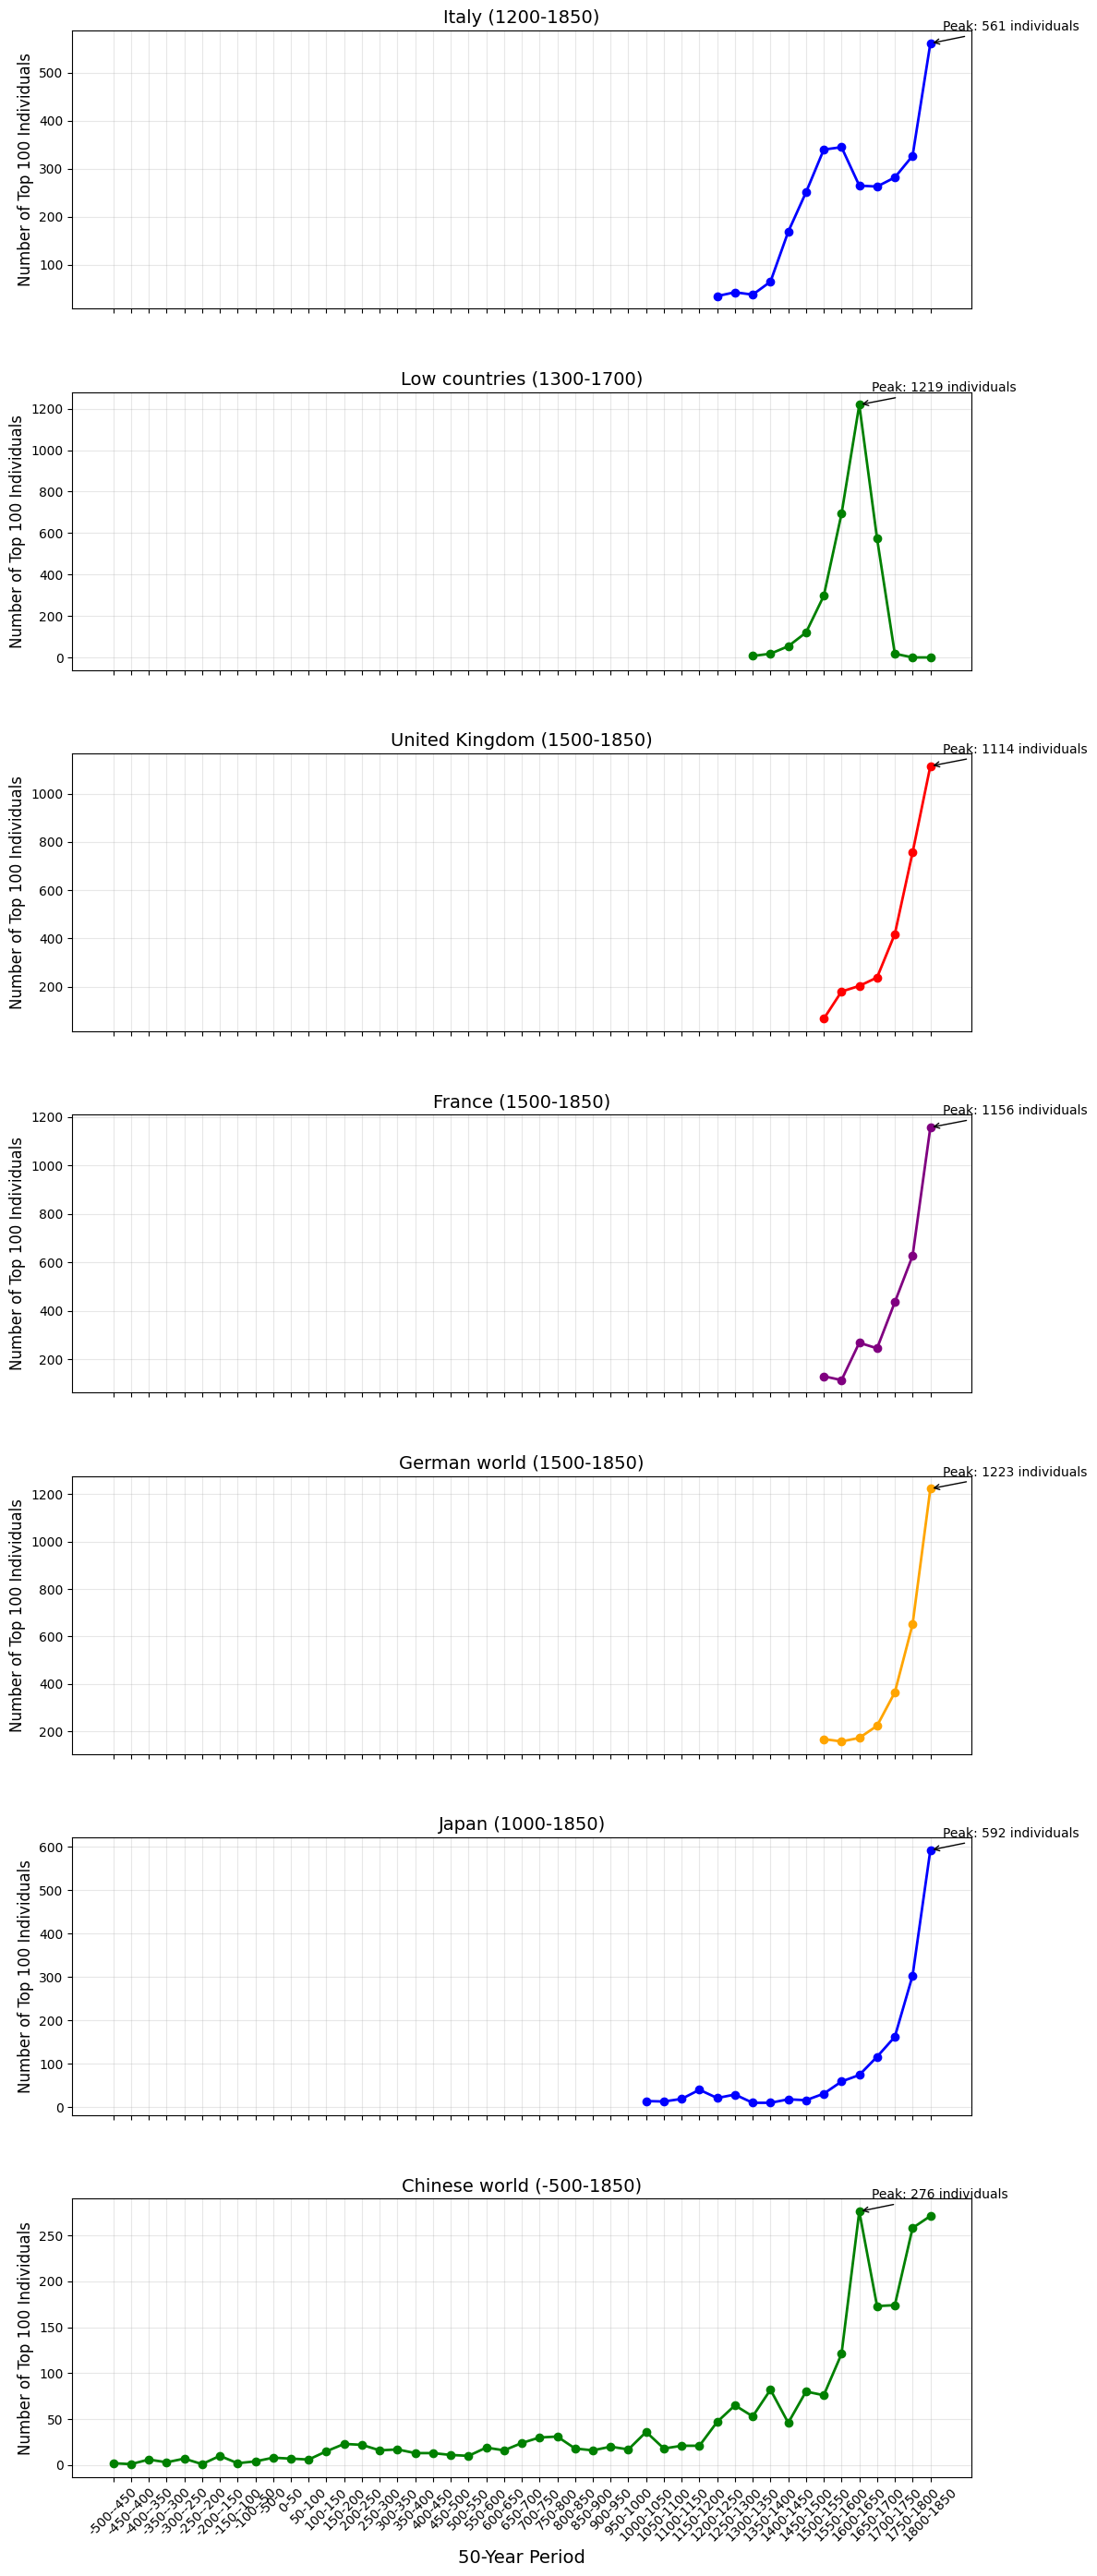

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Define regions and time periods of interest
regions_periods = {"Italy":(1200, 1850),
    "Low countries": (1300, 1700),
    "United Kingdom": (1500, 1850),
    "France": (1500, 1850),
    "German world": (1500, 1850),
    "Japan": (1000, 1850),
    "Chinese world":(-500, 1850)
}

# Create df_final with the specific time periods for each region
df_filtered_list = []

for region, (start_year, end_year) in regions_periods.items():
    # Filter by region and time period
    region_data = data[(data['region_name'] == region) & 
                      (data['birthyear'] >= start_year) & 
                      (data['birthyear'] <= end_year)]
    
    # Sort by score (descending) and take top 100
    region_data = region_data.sort_values('score', ascending=False).head(3000)
    
    df_filtered_list.append(region_data)

# Combine all filtered data
df_final = pd.concat(df_filtered_list)

# Create 50-year period bins
df_final['period'] = ((df_final['birthyear'] // 50) * 50).astype(int)

# Create subplots for each region
fig, axes = plt.subplots(len(regions_periods), 1, figsize=(12, 4*len(regions_periods)), sharex=True)

# Set a different color for each region
colors = ['blue', 'green', 'red', 'purple', 'orange']

# Plot each region separately
for i, (region, period) in enumerate(regions_periods.items()):
    # Filter data for this region
    region_data = df_final[df_final['region_name'] == region]
    
    # Count individuals by 50-year period for this region
    period_counts = region_data.groupby('period').size().reset_index(name='count')
    
    # Create a DataFrame to ensure all 50-year periods are represented
    start_period = (period[0] // 50) * 50
    end_period = 1850
    all_periods = pd.DataFrame({'period': range(start_period, end_period, 50)})
    
    # Merge with the counts
    plot_data = all_periods.merge(period_counts, on='period', how='left').fillna(0)
    
    # Plot on the corresponding subplot
    ax = axes[i]
    ax.plot(plot_data['period'], plot_data['count'], marker='o', linestyle='-', 
            color=colors[i % len(colors)], linewidth=2)
    
    # Add labels
    ax.set_title(f'{region} ({period[0]}-{period[1]})', fontsize=14)
    ax.set_ylabel('Number of Top 100 Individuals', fontsize=12)
    ax.grid(True, alpha=0.3)
    
    # Add period labels (e.g., "1500-1550")
    period_labels = [f"{p}-{p+50}" for p in plot_data['period']]
    ax.set_xticks(plot_data['period'])
    ax.set_xticklabels(period_labels, rotation=45)
    
    # Annotate some notable points
    if len(period_counts) > 0:
        max_count_idx = period_counts['count'].idxmax()
        max_period = period_counts.loc[max_count_idx, 'period']
        max_count = period_counts.loc[max_count_idx, 'count']
        if max_count > 0:
            ax.annotate(f'Peak: {int(max_count)} individuals',
                       xy=(max_period, max_count),
                       xytext=(10, 10),
                       textcoords='offset points',
                       arrowprops=dict(arrowstyle='->'))

# Set the x-axis label on the bottom subplot
axes[-1].set_xlabel('50-Year Period', fontsize=14)

# Adjust layout and spacing
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
plt.show()

In [5]:
df_final = df_final.reset_index(drop=True)
df_api = df_final[df_final['region_name'].isin(['Italy'])]
df_api = df_api[:1500].copy()
# df_api = df_api[:3]
df_api


,individual_wikidata_id,individual_name,score,productive_year,birthyear,country_name,region_name,period
0,Q1067,Dante Alighieri,276,1300.0,1265.0,Italy,Italy,1250
1,Q1511,Richard Wagner,250,1848.0,1813.0,Italy,Italy,1800
2,Q5592,Michelangelo,235,1510.0,1475.0,Italy,Italy,1450
3,Q307,Galileo Galilei,230,1599.0,1564.0,Italy,Italy,1550
4,Q1401,Petrarch,227,1339.0,1304.0,Italy,Italy,1300
...,...,...,...,...,...,...,...,...
1495,Q1514544,Gerolamo Boccardo,45,1864.0,1829.0,Italy,Italy,1800
1496,Q4107591,Giovanni Maria Verdizotti,45,1565.0,1530.0,Italy,Italy,1500
1497,Q1528003,Giulio Campi,45,1537.0,1502.0,Italy,Italy,1500
1498,Q3768932,Girolamo Gigli,45,1695.0,1660.0,Italy,Italy,1650


### Run the process

In [6]:
# Get total number of items to process
total_items = len(df_api)

# Calculate number of batches needed
batch_size = 200
num_batches = (total_items + batch_size - 1) // batch_size

In [6]:

# # Process each batch
# for batch_num in range(num_batches):
#     # Calculate start and end indices for the current batch
#     start_idx = batch_num * batch_size
#     end_idx = min((batch_num + 1) * batch_size, total_items)
    
#     print(f"Processing batch {batch_num+1}/{num_batches} (items {start_idx+1}-{end_idx})")
    
#     # Extract the batch from the dataframe
#     batch_df = df_api.iloc[start_idx:end_idx]
    
#     # Process the batch
#     batch_results = process_authors(batch_df)
    
#     # Convert results to dataframe
#     batch_df_results = pd.DataFrame(batch_results).T.reset_index()
#     batch_df_results = batch_df_results.rename(columns={'index': 'individual_wikidata_id'})
    
#     # Save the batch results to a CSV file
#     batch_save_path = f"data/social_origins/italy/italy_top_{start_idx+1}_to_{end_idx}.csv"
#     batch_df_results.to_csv(batch_save_path)
#     print(f"Saved batch results to {batch_save_path}")

In [ ]:

# # After all batches are processed, optionally combine them into a single file
# all_dfs = []
# for batch_num in range(num_batches):
#     start_idx = batch_num * batch_size
#     end_idx = min((batch_num + 1) * batch_size, total_items)
    
#     batch_file = f"data/social_origins/uk/UK_top_{start_idx+1}_to_{end_idx}.csv"
#     batch_df = pd.read_csv(batch_file)
#     all_dfs.append(batch_df)

# # Combine all batches into a single dataframe
# combined_df = pd.concat(all_dfs, ignore_index=True)

# # Save the combined results
# combined_df.to_csv('data/social_origins/UK_top_300_to_1000.csv')

In [12]:
# results = process_authors(df_api)

# df_results = pd.DataFrame(results).T.reset_index()

# df_results = df_results.rename(columns={'index':'individual_wikidata_id'})
# df_results.to_csv('data/social_origins/china_top_1500.csv')

### Plot results

In [31]:
df_uk = pd.read_csv('data/social_origins/uk_top_1701.csv')
(1 - len(df_uk.dropna())/len(df_uk))*100

4.644326866549086

In [10]:
import pandas as pd
import glob
import os

# Path to the UK data files
uk_files_path = "data/social_origins/italy/*.csv"

# Use glob to get all matching files
uk_files = glob.glob(uk_files_path)

# Initialize an empty list to store individual dataframes
dfs = []

# Read each file and append to the list
for file in uk_files:
    df = pd.read_csv(file, index_col = [0])
    dfs.append(df)

# Concatenate all dataframes into a single dataframe
df_results = pd.concat(dfs, ignore_index=True)
df_results.drop_duplicates().to_csv('data/social_origins/italy_top_1500.csv')


In [11]:


# # Path to the UK data files
# uk_files_path = "data/social_origins/japan_2/*.csv"

# # Use glob to get all matching files
# uk_files = glob.glob(uk_files_path)

# # Initialize an empty list to store individual dataframes
# dfs = []

# # Read each file and append to the list
# for file in uk_files:
#     df = pd.read_csv(file, index_col = [0])
#     dfs.append(df)

# # Concatenate all dataframes into a single dataframe
# df_results_2 = pd.concat(dfs, ignore_index=True)


# df_results = pd.concat([df_results_1, df_results_2])
# df_results = df_results.drop_duplicates()
# df_results

In [ ]:

# df_results.to_csv('data/social_origins/japan_top_1500.csv')

In [12]:
len(df_results.dropna())/len(df_results)

0.905811623246493

In [ ]:




# df_results.to_csv('data/social_origins/uk_top_900.csv')

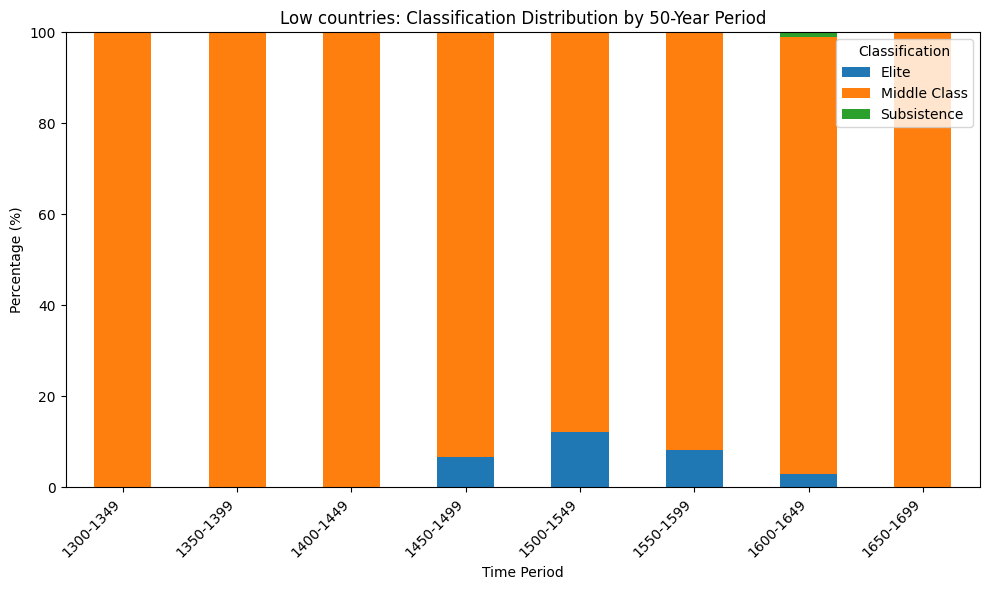

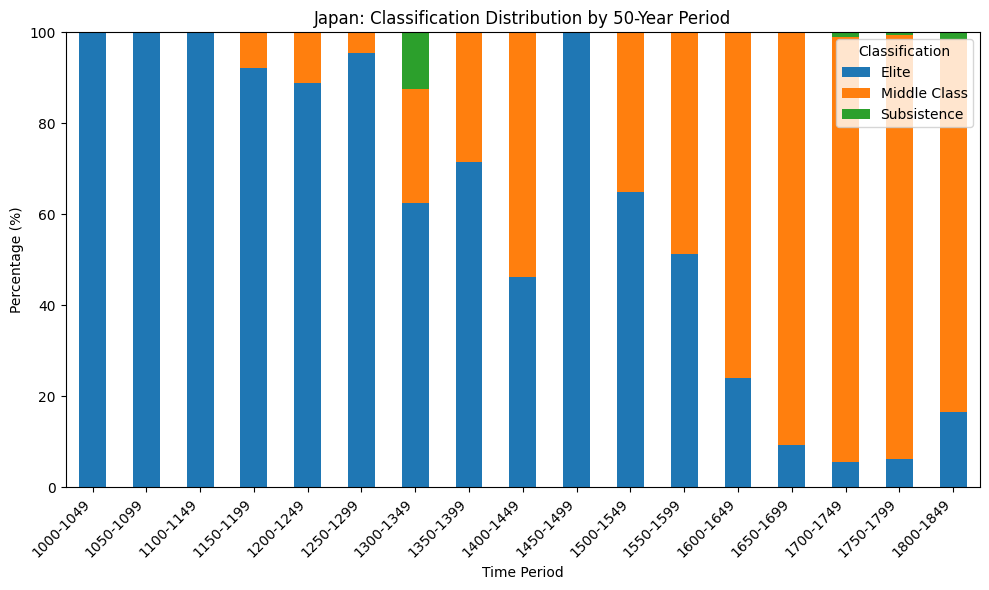

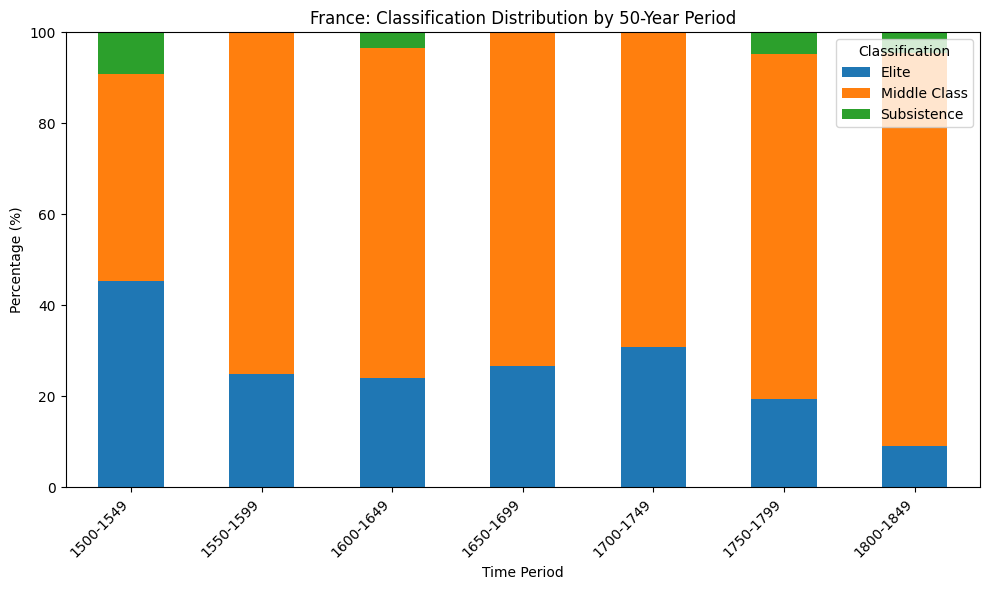

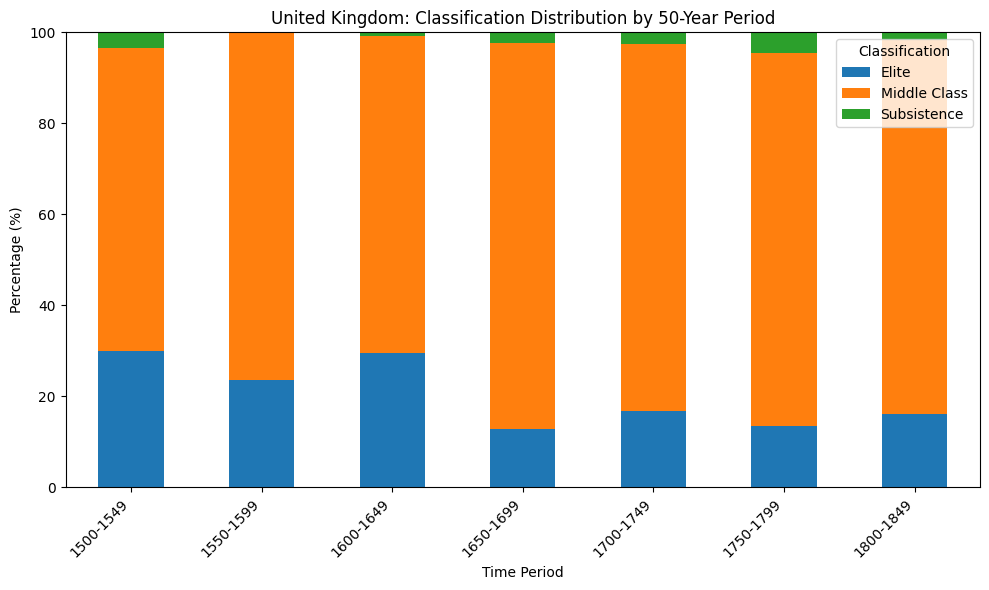

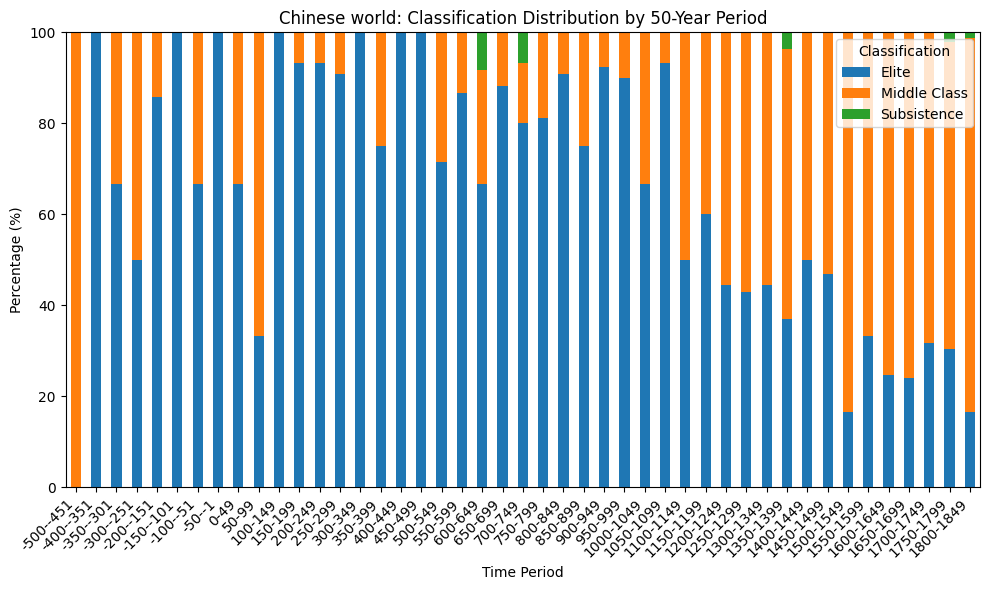

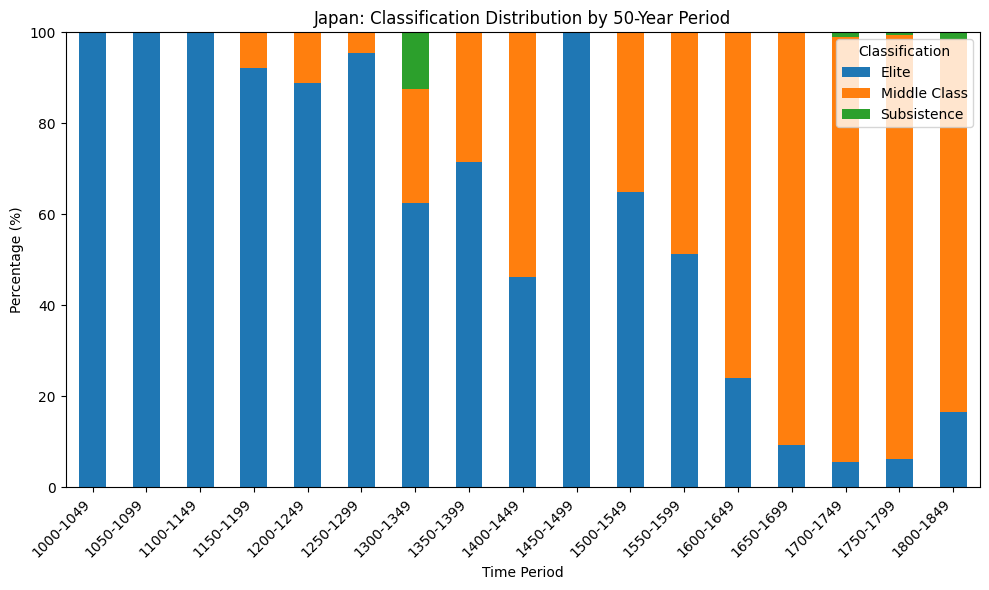

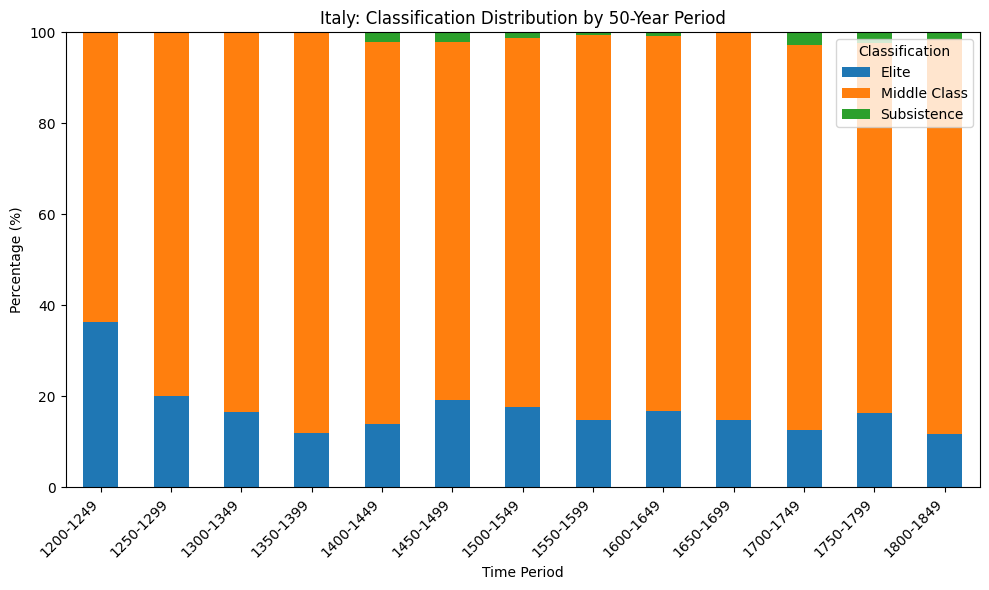

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_normalized_classification(data_path, region_name, figsize=(10, 6)):
    """
    Create a normalized stacked bar chart of classifications by time period for a specific region.
    
    Parameters:
    -----------
    data_path : str
        Path to the CSV file containing the data
    region_name : str
        Name of the region to analyze (e.g., 'France', 'Low countries')
    df_final_path : str, optional
        Path to the df_final CSV file. If None, assumes df_final is already defined in the global scope
    figsize : tuple, optional
        Figure size as (width, height) in inches
        
    Returns:
    --------
    fig, ax : tuple
        Figure and axes objects for further customization if needed
    """
    # Read the initial dataset
    df_results = pd.read_csv(data_path, index_col=[0])

    
    df_fig = pd.merge(df_results, df_final, on='individual_wikidata_id')
    df_fig = df_fig[['individual_wikidata_id', 'birthyear', 'classification', 'region_name']].copy()
    df_fig = df_fig.dropna()
    
    # Round birthyear to nearest 50-year period
    df_fig['period'] = (df_fig['birthyear'] // 50) * 50
    
    # Group by region, period, and classification to get absolute counts
    period_counts = df_fig.groupby(['region_name', 'period', 'classification']).size().unstack(fill_value=0)
    
    # Filter out the 1850-1899 period if needed
    filtered_period_counts = period_counts.copy()
    if 1850 in [idx[1] for idx in period_counts.index if idx[0] == region_name]:
        filtered_period_counts = period_counts[~(period_counts.index.get_level_values('period') == 1850)]
    
    # Use the filtered data going forward
    period_counts = filtered_period_counts
    
    # Calculate the total for each period for normalization
    period_totals = period_counts.sum(axis=1)
    
    # Set up the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    if region_name in period_counts.index.get_level_values('region_name'):
        # Get data for the specified region
        region_data = period_counts.xs(region_name, level='region_name')
        
        # Filter out the 1850-1899 period more explicitly
        if 1850 in region_data.index:
            region_data = region_data.drop(1850)
        
        # Sort by period
        region_data = region_data.sort_index()
        
        # Normalize data (convert to percentages)
        normalized_data = region_data.div(region_data.sum(axis=1), axis=0) * 100
        
        # Plot the normalized stacked bar chart
        normalized_data.plot(kind='bar', stacked=True, ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
        
        # # Add percentage annotations
        # for i in range(len(normalized_data)):
        #     y_offset = 0
        #     period = normalized_data.index[i]
        #     total_count = period_totals.loc[(region_name, period)]
            
        #     for j in range(len(normalized_data.columns)):
        #         percentage = normalized_data.iloc[i, j]
        #         count = region_data.iloc[i, j]
                
        #         if percentage > 0:
        #             ax.text(i, y_offset + percentage/2, f"{int(count)}\n({percentage:.1f}%)",
        #                   ha='center', va='center', color='white', fontweight='bold', size=8)
        #             y_offset += percentage
        
        # Format x-axis tick labels to show the 50-year period range
        x_labels = [f"{int(period)}-{int(period)+49}" for period in normalized_data.index]
        ax.set_xticklabels(x_labels, rotation=45, ha='right')
        
        # Set titles and labels
        ax.set_title(f'{region_name}: Classification Distribution by 50-Year Period')
        ax.set_ylabel('Percentage (%)')
        ax.set_xlabel('Time Period')
        ax.set_ylim(0, 100)  # Set y-axis to go from 0 to 100%
        
        # Add legend with a title
        ax.legend(title='Classification',loc='upper right')
        
        # Adjust layout to prevent cutting off labels
        plt.tight_layout()
        
        return fig, ax
    else:
        print(f"No data available for {region_name}")
        return None, None

# Example usage:
fig, ax = plot_normalized_classification(
    data_path='data/social_origins/low_countries_top_300.csv',
    region_name='Low countries',
)
plt.show()

# Example usage:
fig, ax = plot_normalized_classification(
    data_path='data/social_origins/japan_top_1500.csv',
    region_name='Japan',
)
plt.show()

# Example usage:
fig, ax = plot_normalized_classification(
    data_path='data/social_origins/france_top_300.csv',
    region_name='France',
)
plt.show()

# Example usage:
fig, ax = plot_normalized_classification(
    data_path='data/social_origins/uk_top_1701.csv',
    region_name='United Kingdom',
)
plt.show()


# Example usage:
fig, ax = plot_normalized_classification(
    data_path='data/social_origins/china_top_1500.csv',
    region_name='Chinese world',
)
plt.show()

# Example usage:
fig, ax = plot_normalized_classification(
    data_path='data/social_origins/japan_top_1500.csv',
    region_name='Japan',
)
plt.show()

# Example usage:
fig, ax = plot_normalized_classification(
    data_path='data/social_origins/italy_top_1500.csv',
    region_name='Italy',
)
plt.show()

In [9]:
import pandas as pd
data = pd.read_csv('data/social_origins/uk_top_1701.csv', index_col = [0])
data = data.dropna()
data[data['classification'].str.contains('Subs')].iloc[2]['explanation']

'Robert Dodsley was born in 1703 in Mansfield, Nottinghamshire, England. His father, Robert Dodsley Sr., was a schoolmaster, but the family was not well-off. In fact, they were quite poor. Dodsley himself had little formal education, and he was apprenticed to a stocking weaver at a young age, indicating that his family was not able to provide him with a more prestigious or lucrative apprenticeship. His early life was marked by poverty and hardship, which suggests that his family belonged to the lower social class.'

In [15]:
df_results = pd.read_csv('data/social_origins/uk_top_1701.csv', index_col = [0])
df_results = pd.read_csv('data/social_origins/china_top_1500.csv', index_col = [0])
df_results = pd.read_csv('data/social_origins/japan_top_1500.csv', index_col = [0])
df_results = pd.read_csv('data/social_origins/italy_top_1500.csv', index_col = [0])

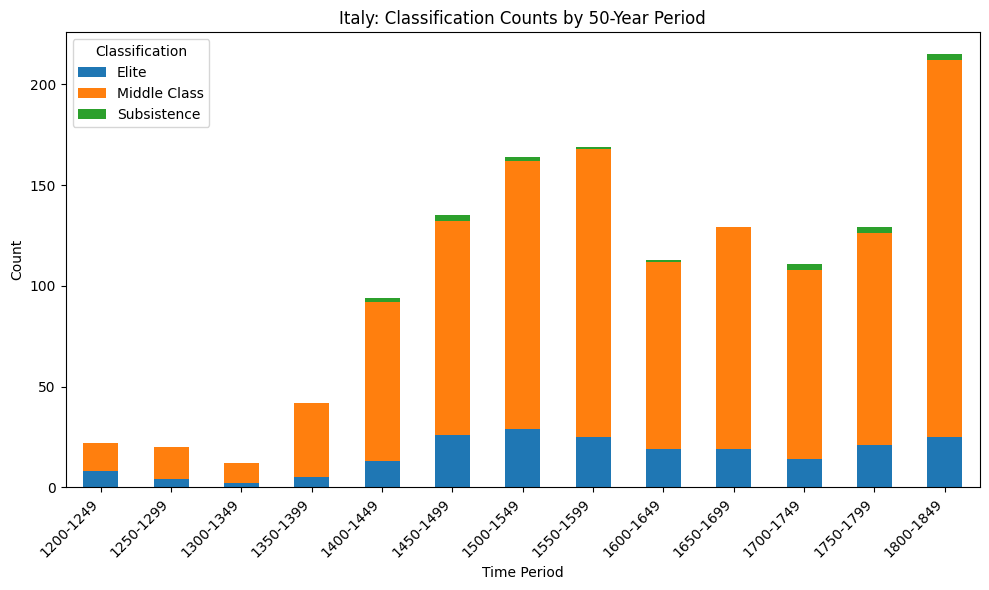

In [19]:



df_fig = pd.merge(df_results, df_final, on = 'individual_wikidata_id')
df_fig = df_fig[['individual_wikidata_id', 'birthyear', 'classification', 'region_name']].copy()
df_fig = df_fig.dropna()


country = 'Italy'


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Round birthyear to nearest 50-year period
df_fig['period'] = (df_fig['birthyear'] // 50) * 50

# Group by region, period, and classification to get absolute counts
period_counts = df_fig.groupby(['region_name', 'period', 'classification']).size().unstack(fill_value=0)

# Filter out the 1850-1899 period
filtered_period_counts = period_counts.copy()
if 1850 in [idx[1] for idx in period_counts.index if idx[0] == country]:
    filtered_period_counts = period_counts[~(period_counts.index.get_level_values('period') == 1850)]

# Use the filtered data going forward
period_counts = filtered_period_counts

# Calculate the total for each period to help with percentage calculation
period_totals = period_counts.sum(axis=1)

# Set up the plot - now just a single plot
fig, ax = plt.subplots(figsize=(10, 6))

# Plot for France - using absolute counts
if country in period_counts.index.get_level_values('region_name'):
    # Get data for France
    france_data = period_counts.xs(country, level='region_name')
    
    # Filter out the 1850-1899 period more explicitly
    if 1850 in france_data.index:
        france_data = france_data.drop(1850)
    
    # Sort by period if needed
    france_data = france_data.sort_index()
    
    # Plot the stacked bar chart
    france_data.plot(kind='bar', stacked=True, ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    
    # # Add count and percentage annotations
    # for i in range(len(france_data)):
    #     y_offset = 0
    #     period = france_data.index[i]
    #     total = period_totals.loc[(country, period)]
        
    #     for j in range(len(france_data.columns)):
    #         count = france_data.iloc[i, j]
    #         if count > 0:
    #             percentage = (count / total) * 100
    #             ax.text(i, y_offset + count/2, f"{int(count)}\n({percentage:.1f}%)",
    #                   ha='center', va='center', color='white', fontweight='bold', size=8)
    #             y_offset += count
    
    # Format x-axis tick labels to show the 50-year period range
    # Create labels in the format "1500-1549", "1550-1599", etc.
    x_labels = [f"{int(period)}-{int(period)+49}" for period in france_data.index]
    ax.set_xticklabels(x_labels, rotation=45, ha='right')
    
    # Set titles and labels
    ax.set_title(f'{country}: Classification Counts by 50-Year Period')
    ax.set_ylabel('Count')
    ax.set_xlabel('Time Period')
    
    # Add legend with a title
    ax.legend(title='Classification')
    
    # Adjust layout to prevent cutting off labels
    plt.tight_layout()
    
    # Display the plot
    plt.show()
else:
    print("No data available for France")